In [2]:

%pip install torch
%pip install torchvision

^C
Note: you may need to restart the kernel to use updated packages.
  Using cached torchvision-0.14.1-cp310-cp310-win_amd64.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ggiro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


     -------------------------------------- 162.6/162.6 MB 9.8 MB/s eta 0:00:00
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)


You should consider upgrading via the 'c:\Users\ggiro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
%pip install --upgrade numpy

^C
Note: you may need to restart the kernel to use updated packages.


     --------------------------------------- 14.8/14.8 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3


You should consider upgrading via the 'c:\Users\ggiro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from PIL import Image,ImageOps
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from skimage import io
import os
import cv2

In [1]:
pathToCategories = "./baseline/baseline/"
def init_dataset(labels):
    """
    fonction pour récupérer le chemin vers les données d'entrée et les données de validation de la segmentaiton (groundtruth)
    Args:
        labels: labels des vidéos dont on veut récupérer les données.
    """
    input_data = {}
    groundTruth_data = {}
    nb_image = {}
    i=0
    for label in labels:
        input_data[label] = [str(p) for p in Path(
            pathToCategories+label+"/input/").glob('*.jpg')]
        groundTruth_data[label] = [str(p) for p in Path(
            pathToCategories+label+"/groundtruth/").glob('*.png')]
        nb_image[label] = len(input_data[label])
    return nb_image,input_data,groundTruth_data


In [50]:
def output_dataset(labels):
    """
    fonction pour récupérer le chemin vers les données obtenue en sortie des méthodes de segmentation implémentés
    Args:
        labels: labels des vidéos dont on veut récupérer les données.
    """
    output_data_sem_seg = {}
    output_data_vibe = {}
    nb_image = {}
    i=0
    for label in labels:
        output_data_sem_seg[label] = [str(p) for p in Path(
            pathToCategories+label+"/output_sem_seg/").glob('*.jpg')]
        output_data_vibe[label] = [str(p) for p in Path(
            pathToCategories+label+"/output_vibe/").glob('*.jpg')]
        #nb_image[label] = len(output_data_sem_seg[label])
    return output_data_sem_seg,output_data_vibe

In [51]:
labels=["highway", "office", "pedestrians", "PETS2006"]
output_data_sem_seg,output_data_vibe=output_dataset(labels)

In [52]:
nb_image,input_data,groundTruth_data=init_dataset(labels)

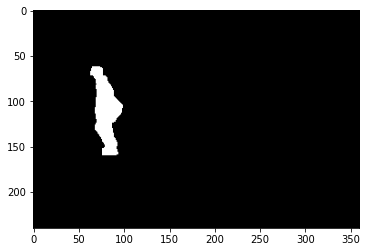

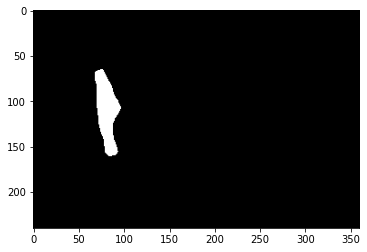

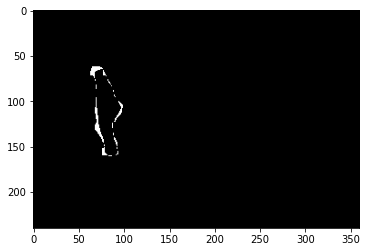

[  0 255]
[  0 255]


(array([-255.,    0.,  255.]), array([  328, 86031,    41], dtype=int64))

In [7]:
im_out=io.imread(output_data_vibe["pedestrians"][1010])
im_out=io.imread(output_data_sem_seg["pedestrians"][1010])
im_out[im_out==188]=255
grdtruth=io.imread(groundTruth_data["pedestrians"][1010])
#grdtruth[grdtruth>=170]=255
grdtruth[grdtruth>=50]=255

#sol pour plus de perf pour vibe
#im_out=cv2.blur(im_out,(5,5))
#im_out[im_out!=0]=255 -> seuil(ici =0) réglable

#grdtruth[grdtruth<=170]=0
#grdtruth[grdtruth<=50]=0
plt.imshow(grdtruth,cmap="gray")
plt.show()
plt.imshow(im_out,cmap="gray")
plt.show()
plt.imshow(abs(im_out.astype(float)-grdtruth.astype(float)),cmap="gray")
plt.show()
print(np.unique(grdtruth))
print(np.unique(im_out))
#print(np.unique(im_g-im_out,return_counts=True))
np.unique(im_out.astype(float)-grdtruth.astype(float),return_counts=True)

In [99]:
def PercentageCorrectClassification(img,groundtruth):
    res=np.unique(img.astype(float)-groundtruth.astype(float),return_counts=True)
    #FN=res[1][0]
    #TPandTN=res[1][1]
    #FP=res[1][2]
    count={0:0,-1:0,254:0,-255:0}
    for i in range(len(res[0])):
        count[res[0][i]]=res[1][i]
        FN=count[-255]
        TN=count[-1]
        TP=count[0]
        FP=count[254]
    PCC=(TP+TN)/(TP+TN+FP+FN)
    return PCC

In [103]:
PercentageCorrectClassification(im_out,grdtruth)

0.997464162478868

In [71]:
def classifactionMetrics(img,groundtruth):
    groundtruth_c=np.copy(groundtruth)
    groundtruth_c[groundtruth_c==0]=1 #pour pouvoir distinguer TN de TP
    res=np.unique(img.astype(float)-groundtruth_c.astype(float),return_counts=True)
    #FN=res[1][0]
    #TN=res[1][1]
    #TP=res[1][2]
    #FP=res[1][3]
    count={0:0,-1:0,254:0,-255:0}
    for i in range(len(res[0])):
        count[res[0][i]]=res[1][i]
        FN=count[-255]
        TN=count[-1]
        TP=count[0]
        FP=count[254]
    print(FP)
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    f1_score=2*precision*recall/(precision+recall)
    return precision,recall,f1_score

In [8]:
def jaccardCoeff(img,groundtruth,positiveClass="foreground"):
    """
    fonction pour mesurer l'indice de Jaccard pour une segmenation donnée
    Args:
        img: image qui contient la segmentation dont on veut mesurer l'indice
        groundtruth: solution de la segmentation
        positiveClass: partie de la segmentation que l'on considère comme la calsse positive.
        Par défaut, il s'agit du premier-plan (régions d'intérets).
    """
    groundtruth_c=np.copy(groundtruth)
    groundtruth_c[groundtruth_c==0]=1 #pour pouvoir distinguer TN de TP
    res=np.unique(img.astype(float)-groundtruth_c.astype(float),return_counts=True)
    count={0:0,-1:0,254:0,-255:0}
    for i in range(len(res[0])):
        count[res[0][i]]=res[1][i]
        FN=count[-255]
        TN=count[-1]
        TP=count[0]
        FP=count[254]
    if positiveClass=="foreground":
        if (TP+FP+FN)==0:
            coeff=1
        else:
            coeff=TP/(TP+FP+FN)
    else:
        coeff=TN/(TN+FP+FN)
    return coeff

In [117]:
classifactionMetrics(im_out,grdtruth)

659


(0.568717277486911, 0.9294117647058824, 0.7056435241575315)

In [136]:
jaccardCoeff(im_out,grdtruth)

0.8073107049608355

### Segmentation sémantique

In [ ]:
#fonction appliquant du pre-traitement aux cathegories dimage recu et retournant la liste des images retransforme en Tensor

preprocessing = transforms.Compose([
    transforms.ToTensor(),
])

def get_input_tensor(input_data):
    input_tensor_label = {}
    input_tensor_label = []
    for input in input_data:
        tensor = preprocessing(Image.fromarray(io.imread(input)))
        input_tensor_label.append(tensor)
    return input_tensor_label

In [ ]:
# retourne les images en batch empiler pour envoyer à l'analyse
def stack_input_tensor(input_tensor_label):
    input_batch_tensor_label=torch.stack(input_tensor_label, 0)
    return input_batch_tensor_label


In [ ]:
#applique l'analyse de la segmentation semantique avec le modele DeepLabV3 prenant comme squellette le reseau resnet101
def evaluate(input_batch_tensor_label):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
    predictions = {}
    with torch.no_grad():
        predictions = model(input_batch_tensor_label)
    return predictions

In [ ]:
#fonction de coloration des regions dinteret apres la segmentation
def draw_segmentation_mask(image,nb_class):
  name_colors=list(mcolors.CSS4_COLORS.keys())[7+1:7+nb_class]
  rgb_colors=np.array([(np.array(mcolors.to_rgb(i))*255).astype("uint8") for i in name_colors])
  COLORS = np.vstack([[0, 0, 0], rgb_colors]).astype("uint8")
  COLORS[15] = [255,255,255] #class pour lidentification de personnes
  image.putpalette(COLORS)
  return image

#### Fonction Main de lexecution pour obtenir la segmentation sementique

In [ ]:
#fonction principale dacquisition des resultats pour la segmentation sementique, les resultats sont mis dans le dossier "output_seg_sem"
labels = ["highway", "office", "pedestrians", "PETS2006"]
batchSize = 4 #nombre d'images prises par batch d'analyse de segmentation
print("initialising dataset: ",labels," with batchSize = ",batchSize)
nb_image, input_data, true_data = init_dataset(labels) # recuperation du repertoire des data et du nombre dimage a traiter
mini_input_data={}
for label in labels:
    print("current label :",label)
    current = 0 # position de limage se faisant traiter
    anounce_ID =250 # donne un indice de progression a vhaque 250 images traitées
    while(current < nb_image[label]):
        if current > anounce_ID:
            print("are now at", anounce_ID)
            anounce_ID +=250
        if (current+batchSize) > nb_image[label]: #prend en consideration de sil reste moins de 4 images a traiter
            mini_input_data[label]=input_data[label][current:-1]
            current = nb_image[label]
        else:
            mini_input_data[label]=input_data[label][current:(current+batchSize)]
            current += batchSize

        input_tensor_label = get_input_tensor(mini_input_data[label]) #convertie les images en tensor
        input_batch_tensor_label = stack_input_tensor(input_tensor_label) # empiles les images
        predictions = evaluate(input_batch_tensor_label) # applique la prediction
        nb_class = predictions['out'].shape[1]
        for i in range(len(mini_input_data[label])):
            prediction = torch.argmax(predictions['out'][i].squeeze(), dim=0).detach().cpu().numpy().astype(np.uint8)
            masks = Image.fromarray(prediction)
            segmentation_mask=draw_segmentation_mask(masks,nb_class) # dessine les regions dinteret
            segmentation_mask = ImageOps.grayscale(segmentation_mask) # convertie la couleur des regions en grayscale
            segmentation_mask.save(mini_input_data[label][i].replace("input","output_sem_seg"),format="PNG") #enregistre limage




initialising dataset:  ['highway']  with batchSize =  4
current label : highway
are now at 250
are now at 500
are now at 750
are now at 1000
are now at 1250
are now at 1500


### Soustraction d'arrière-plan

In [9]:
from random import randrange
import random
def initBackground(frame,nb_samples,gray_scale=False):
    """
    Cette méthode permet d'initialiser le modèle de l'arrière plan pour la méthode ViBe.
    Args:
        frame: première frame, utilisé pour initialiser le modèle.
        nb_samples: nombre d'échantillons pour une position dans le modèle 
        gray_scale: si les frames du jeux de données sont en niveau de gris
    """
    frame_size=np.shape(frame)

    if gray_scale:
        #Si le jeux de données sont en niveau de gris 
        background=np.empty((frame_size[0],frame_size[1],nb_samples))    
    else:
        #Si le jeux de données sont RGB
        background=np.empty((frame_size[0],frame_size[1],nb_samples,3))
    
    #Pour chaque position dans la frame: on pioche un voisin au hasard pour chaque échantillon du modèle d'arrière-plan
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            #Si la position n'est pas sur le coté bas ou droit de la frame
            if i<frame_size[0]-1 and j<frame_size[1]-1:
                #Si la position n'est pas sur le coté haut ou gauche de la frame
                if i>=1 and j>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est sur le coté gauche de la frame       
                elif i>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est sur le coté haut de la frame 
                elif j>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est dans le coin supérieur gauche de la frame
                else:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([          [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
            #Si la position est sur le coté droit de la frame 
            elif i<frame_size[0]-1:
                #Si la position n'est pas sur le coté haut de la frame 
                if i>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j],])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est sur le coin supérieur droit de la frame 
                else:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i, j-1], 
                                                  [i+1, j-1], [i+1, j]])
                        background[i,j,k]=frame[i_n,j_n]
            #Si la position est sur le coté bas de la frame 
            elif j<frame_size[1]-1:
                #Si la position n'est pas sur le coté gauche de la frame 
                if j>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est sur le coin inférieur gauche de la frame 
                else:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
            else:
                #Si la position est sur le coin inférieur droit de la frame 
                for k in range(nb_samples):
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])
                    background[i,j,k]=frame[i_n,j_n]

    return background      




In [6]:
labels=["highway", "office", "pedestrians", "PETS2006"]
nb_images,input_data,groundTruth_data=init_dataset(labels)

In [10]:
def segmentationViBe4(frame,background_model,R,seuil,nb_samples,random_subsampling):
    """
    Cette méthode permet d'appliquer une segmentation binaire par la méthod ViBe de la frame passé en argument.
    Args:
        frame: frame dont on veut connaitre la segmentation.
        background_model: modèle d'arrière plan
        R: rayon de la sphère pour déterminer la proximité d'un pixel avec les échantillons du modèle
        seuil: nombre d'échantillon à l'intérieur de la sphère à partit duquel on considère que le pixel
               (le centre de la sphère) appartient à l'arrière plan 
        nb_samples: nombre d'échantillons pour une position dans le modèle 
        random_subsampling: la probilité que le modèle, à une position donnée, soit mis à jour est de 1/random_subsampling
    """

    frame_size=np.shape(frame)
    res=np.empty((frame_size[0],frame_size[1]))
    #R2=R**2

    #Pour chaque position dans la frame
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            center=frame[i,j]#Le centre de la sphère est le pixel de la frame à la position courante (,j)
            count=0
            #Pour chaque échantillon dans le modèle d'arrière plan à la position (i,j)
            for sample in background_model[i,j]:
                dist_with_center=(np.linalg.norm(center-sample))
                #Si la distance du centre à l'échantillon est inférieur au rayon de la sphère, on incrémente le compteur
                if dist_with_center<R:
                    count+=1
                if count>=seuil:
                    break
            #Si le compteur est supérieur au seuil, on considère que le pixel appartient à l'arrière-plan
            if count>=seuil:
                res[i,j]=0
            else:
                res[i,j]=255

            #Mise à jour du modèle d'arrière plan avec la probabilité 1/random_subsampling    
            update = randrange(random_subsampling)
            if update == 0:
                #l'échantillon qui est mis à jour est tiré au sort
                sample = randrange(nb_samples)
                background_model[i, j, sample] = frame[i, j]

            #Mise à jour du modèle de l'arrièe-plan pour une position voisine de la position actuelle 
            # avec la probabilité 1/random_subsampling     
            update = randrange(random_subsampling)
            if update == 0:
                #L'échantillon qui sera mis à jour est tiré au sort
                sample=randrange(nb_samples)   
                if i < frame_size[0]-1 and j < frame_size[1]-1:
                    if i >= 1 and j >= 1:
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    elif i >= 1:
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                  [i, j+1],
                                                  [i+1, j], [i+1, j+1]])

                    elif j >= 1:
                        #neighbours = frame[i:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    else:
                        #neighbours = frame[i:i+2, j:j+2]
                        i_n, j_n = random.choice([            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
               
                elif i < frame_size[0]-1:
                    if i >= 1:
                        #neighbours = frame[i-1:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                    
                    else:
                        #neighbours = frame[i:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        
                elif j < frame_size[1]-1:
                    if j >= 1:
                        #neighbours = frame[i-1:i+1, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        
                    else:
                        #neighbours = frame[i-1:i+1, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        
                else:
                    #neighbours = frame[i-1:i+1, j-1:j+1]
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])

                
                
                background_model[i_n,j_n,sample]=frame[i,j]
    return res


In [ ]:
import cv2
resize_relation=1

img=io.imread(input_data["highway"][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data["highway"][500:600]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    #res=segmentationViBe2(img,background,0.15,2,nb_samples)
    res=segmentationViBe4(img,background,40,2,nb_samples,40)
for input in input_data["highway"][600:1100]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    #res=segmentationViBe2(img,background,0.15,2,nb_samples)
    res=segmentationViBe4(img,background,40,2,nb_samples,40)
    #Image.fromarray(res).convert('L').save(input.replace("input","output_vibe"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()
    plt.imshow(res,cmap='gray')
    plt.show()


In [ ]:
import cv2
resize_relation=1

img=io.imread(input_data["highway"][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data["highway"][500:600]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    #res=segmentationViBe2(img,background,0.15,2,nb_samples)
    res=segmentationViBe4(img,background,20,2,nb_samples,16)
for input in input_data["highway"][600:1100]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    #res=segmentationViBe2(img,background,0.15,2,nb_samples)
    res=segmentationViBe4(img,background,20,2,nb_samples,16)
    #Image.fromarray(res).convert('L').save(input.replace("input","output_vibe"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()
    plt.imshow(res,cmap='gray')
    plt.show()


#### Optimisation

In [8]:
def plot_hyperparameter_tuning(res,x_label_orientation="horizontal",x_axis_title="Hyper-parameter value"):
    """
    Montre le graph issu de la recherche d'hyperparamètres.

    Args:
        res: dictionnaire où pour une clé correspondant à la valeur donnée à l'hyperparamètre associe 
             le taux moyen d'images correctes obtenu avec ce dernier.
        x_label_orientation: orientation de label de l'axe horizontale ("vertical" ou "horizonal")
        x_axis_title: titre de l'axe des abscisses
    
    """
    plt.plot(res.keys(),res.values(),'-ro')
    keys_with_max=[key for key,value in res.items() if abs(value-max(res.values()))<1e-09]
    print("On obtient l'indice de Jaccard maximal: "+str(max(res.values()))+" pour les valeurs d'hyperparamètre suivantes:\n"+str(keys_with_max))
    for key in keys_with_max:
        axv=plt.axvline(key, color="red", ls="--")
    if x_label_orientation=="vertical":
        plt.xticks(rotation=90)
    plt.ylabel("Indice de Jaccard")
    plt.xlabel(x_axis_title)
    axv.set_label("Meilleure configuration")
    plt.legend()
    plt.show()

In [32]:
import cv2

resize_relation=1
nb_samples=20

PCCs={}
res_to_plot={}


for value in [15,20,25,30,35,40,45]:
    PCCmoy=0
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        PCCs[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
            PCCs[label].append(PercentageCorrectClassification(res,groundtruth))
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        PCCmoy+=np.mean(PCCs[label])
    PCCmoy=PCCmoy/len(labels)
    res_to_plot[value]=PCCmoy
    print("the mean PCC for hyperparameter value="+str(value)+" is "+str(PCCmoy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

the mean PCC for hyperparameter value=15 is 0.729617185771932
the mean PCC for hyperparameter value=20 is 0.741466751657028
the mean PCC for hyperparameter value=25 is 0.7459668234514
the mean PCC for hyperparameter value=30 is 0.7478706055509412
the mean PCC for hyperparameter value=35 is 0.7487857057279134
the mean PCC for hyperparameter value=40 is 0.7490630664740873
the mean PCC for hyperparameter value=45 is 0.7486756416671377


In [25]:
f1_score_plot,precision,recall,f1_score={},{},{},{}
resize_relation=2

for value in [15,20,25,30,35,40]:
    f1_score_moy=0
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        precision[label]=[]
        recall[label]=[]
        f1_score[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
            p,r,f=classifactionMetrics(res,groundtruth)
            precision[label].append(p)
            recall[label].append(r)
            f1_score[label].append(f)
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        f1_score_moy+=np.mean(f1_score[label])
    f1_score_moy=f1_score_moy/len(labels)
    f1_score_plot[value]=f1_score_moy
    print("the mean f1 score for hyperparameter value="+str(value)+" is "+str(f1_score_moy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

the mean f1 score for hyperparameter value=15 is 0.46581772255413084
the mean f1 score for hyperparameter value=20 is 0.5271095179698017
the mean f1 score for hyperparameter value=25 is 0.5605654116207943
the mean f1 score for hyperparameter value=30 is 0.5762989646047191
the mean f1 score for hyperparameter value=35 is 0.5866919038394588
the mean f1 score for hyperparameter value=40 is 0.5850462468002917


In [98]:
jaccard_coeff={}
resize_relation=2
R=20
seuil=2
random_subsampling=16

for nb_samples in [15,20,25,30,35,40,45]:
    coeff_moy=0
    coeff={}
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        coeff[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,R,seuil,nb_samples,random_subsampling)
            coeff[label].append(jaccardCoeff(res,groundtruth))
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        coeff_moy+=np.mean(coeff[label])
    coeff_moy=coeff_moy/len(labels)
    jaccard_coeff[nb_samples]=coeff
    print("the mean jaccard's coefficient for hyperparameter value="+str(nb_samples)+" is "+str(coeff_moy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

the mean jaccard's coefficient for hyperparameter value=15 is 0.4147140545629365
the mean jaccard's coefficient for hyperparameter value=20 is 0.44993411558867746
the mean jaccard's coefficient for hyperparameter value=25 is 0.4710352931550668
the mean jaccard's coefficient for hyperparameter value=30 is 0.48120947134048886
the mean jaccard's coefficient for hyperparameter value=35 is 0.4871544912384885
the mean jaccard's coefficient for hyperparameter value=40 is 0.48973168172449794
the mean jaccard's coefficient for hyperparameter value=45 is 0.49299070947218154


In [99]:
for nb_samples in [50,55,60,65]:
    coeff_moy=0
    coeff={}
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        coeff[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,R,seuil,nb_samples,random_subsampling)
            coeff[label].append(jaccardCoeff(res,groundtruth))
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        coeff_moy+=np.mean(coeff[label])
    coeff_moy=coeff_moy/len(labels)
    jaccard_coeff[nb_samples]=coeff
    print("the mean jaccard's coefficient for hyperparameter value="+str(nb_samples)+" is "+str(coeff_moy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

the mean jaccard's coefficient for hyperparameter value=50 is 0.4941664195962923
the mean jaccard's coefficient for hyperparameter value=55 is 0.49509915322766734
the mean jaccard's coefficient for hyperparameter value=60 is 0.4958883429756337
the mean jaccard's coefficient for hyperparameter value=65 is 0.4929937374579557


In [100]:
for nb_samples in [70,75]:
    coeff_moy=0
    coeff={}
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        coeff[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,R,seuil,nb_samples,random_subsampling)
            coeff[label].append(jaccardCoeff(res,groundtruth))
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        coeff_moy+=np.mean(coeff[label])
    coeff_moy=coeff_moy/len(labels)
    jaccard_coeff[nb_samples]=coeff
    print("the mean jaccard's coefficient for hyperparameter value="+str(nb_samples)+" is "+str(coeff_moy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

the mean jaccard's coefficient for hyperparameter value=70 is 0.4955070620994125
the mean jaccard's coefficient for hyperparameter value=75 is 0.4969807963838031


In [103]:
jaccard_coeff_plot={}
for nb_samples in [15,20,25,30,35,40,45,50,55,60,65,70,75]:
    mean=0
    for label in labels:
        mean+=np.mean(jaccard_coeff[nb_samples][label])
    mean=mean/len(labels)
    jaccard_coeff_plot[nb_samples]=mean
        

On obtient l'indice de Jaccard maximal: 0.4969807963838031 pour les valeurs d'hyperparamètre suivantes:
[75]


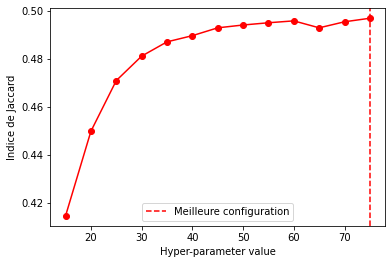

In [104]:
plot_hyperparameter_tuning(jaccard_coeff_plot)

In [87]:
jaccard_coeff={}
resize_relation=2

for value in [15,20,25,30,35,40,45]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,2,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,2,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff[value]))

the mean jaccard's coefficient for hyperparameter value=15 is 0.5785034534927529
the mean jaccard's coefficient for hyperparameter value=20 is 0.6068774875317272
the mean jaccard's coefficient for hyperparameter value=25 is 0.6110395620774324
the mean jaccard's coefficient for hyperparameter value=30 is 0.615780567549612
the mean jaccard's coefficient for hyperparameter value=35 is 0.6250248520862323
the mean jaccard's coefficient for hyperparameter value=40 is 0.6280244534441837
the mean jaccard's coefficient for hyperparameter value=45 is 0.6278236784575949


In [88]:
for value in [50,55,60,65]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,2,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,2,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff[value]))

the mean jaccard's coefficient for hyperparameter value=50 is 0.6294881393719333
the mean jaccard's coefficient for hyperparameter value=55 is 0.6188291375056465
the mean jaccard's coefficient for hyperparameter value=60 is 0.6084565734690005
the mean jaccard's coefficient for hyperparameter value=65 is 0.6024567277635445


On obtient l'indice de Jaccard maximal: 0.6294881393719333 pour les valeurs d'hyperparamètre suivantes:
[50]


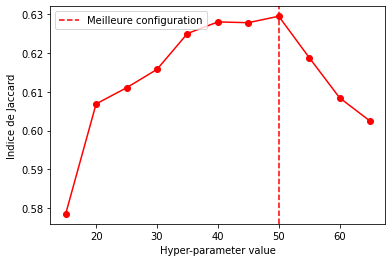

In [95]:
plot_hyperparameter_tuning(jaccard_coeff)

In [97]:
jaccard_coeff2={}
resize_relation=2

for nb_samples in [5,10,15,20,25,30,35,40]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff2[nb_samples]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(nb_samples)+" is "+str(jaccard_coeff2[nb_samples]))

the mean jaccard's coefficient for hyperparameter value=5 is 0.42623877233406804
the mean jaccard's coefficient for hyperparameter value=10 is 0.5851030471578137
the mean jaccard's coefficient for hyperparameter value=15 is 0.6012267736855265
the mean jaccard's coefficient for hyperparameter value=20 is 0.6031697442397256
the mean jaccard's coefficient for hyperparameter value=25 is 0.6041443982204235
the mean jaccard's coefficient for hyperparameter value=30 is 0.6041860212603415
the mean jaccard's coefficient for hyperparameter value=35 is 0.6093627068162963
the mean jaccard's coefficient for hyperparameter value=40 is 0.6109037554909962


In [98]:
for nb_samples in [45,50,55,50]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff2[nb_samples]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(nb_samples)+" is "+str(jaccard_coeff2[nb_samples]))

the mean jaccard's coefficient for hyperparameter value=45 is 0.6088637825253821
the mean jaccard's coefficient for hyperparameter value=50 is 0.6080759206833604
the mean jaccard's coefficient for hyperparameter value=55 is 0.6089661047869036
the mean jaccard's coefficient for hyperparameter value=50 is 0.6083699199575535


On obtient l'indice de Jaccard maximal: 0.6109037554909962 pour les valeurs d'hyperparamètre suivantes:
[40]


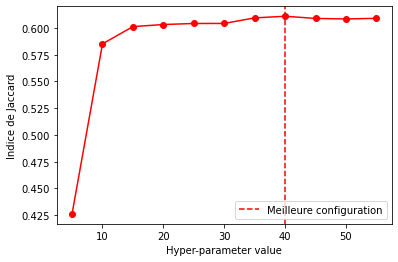

In [99]:
plot_hyperparameter_tuning(jaccard_coeff2)

In [100]:
jaccard_coeff3={}
resize_relation=2
nb_samples=40

for value in [1,2,4,6,8,10,12,15]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,value,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,value,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff3[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff3[value]))

the mean jaccard's coefficient for hyperparameter value=1 is 0.5247362268062862
the mean jaccard's coefficient for hyperparameter value=2 is 0.6080375943924514
the mean jaccard's coefficient for hyperparameter value=4 is 0.6190609071574038
the mean jaccard's coefficient for hyperparameter value=6 is 0.5748565559830896
the mean jaccard's coefficient for hyperparameter value=8 is 0.5073819634432732
the mean jaccard's coefficient for hyperparameter value=10 is 0.42766267768800936
the mean jaccard's coefficient for hyperparameter value=12 is 0.33860149414436974
the mean jaccard's coefficient for hyperparameter value=15 is 0.23266036456039474


On obtient l'indice de Jaccard maximal: 0.6190609071574038 pour les valeurs d'hyperparamètre suivantes:
[4]


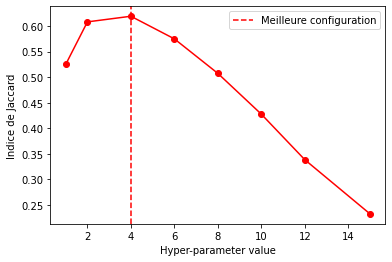

In [101]:
plot_hyperparameter_tuning(jaccard_coeff3)

In [14]:
jaccard_coeff4={}
resize_relation=2
nb_samples=40
seuil=4

for value in [10,20,25,30,35,40,45,50,55,60,65]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff4[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff4[value]))

the mean jaccard's coefficient for hyperparameter value=10 is 0.4485130237126565
the mean jaccard's coefficient for hyperparameter value=20 is 0.6194223648821724
the mean jaccard's coefficient for hyperparameter value=25 is 0.6458666206129723
the mean jaccard's coefficient for hyperparameter value=30 is 0.6612591326401006
the mean jaccard's coefficient for hyperparameter value=35 is 0.6732821005723987
the mean jaccard's coefficient for hyperparameter value=40 is 0.6818576156241567
the mean jaccard's coefficient for hyperparameter value=45 is 0.6915770685143042
the mean jaccard's coefficient for hyperparameter value=50 is 0.6950680426971242
the mean jaccard's coefficient for hyperparameter value=55 is 0.689321738292107
the mean jaccard's coefficient for hyperparameter value=60 is 0.6848548389636163
the mean jaccard's coefficient for hyperparameter value=65 is 0.6810435079584206


On obtient l'indice de Jaccard maximal: 0.6950680426971242 pour les valeurs d'hyperparamètre suivantes:
[50]


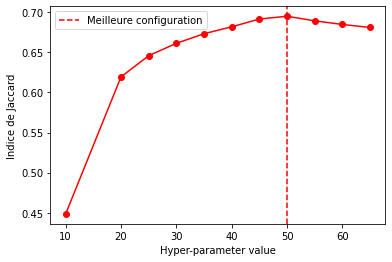

In [17]:
plot_hyperparameter_tuning(jaccard_coeff4)

In [18]:
jaccard_coeff5={}
resize_relation=2
nb_samples=40
seuil=4
rayon=50

for value in [5,10,16,20,25,30]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff5[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff5[value]))

the mean jaccard's coefficient for hyperparameter value=5 is 0.6023484113615829
the mean jaccard's coefficient for hyperparameter value=10 is 0.6701033875636467
the mean jaccard's coefficient for hyperparameter value=16 is 0.6943224888955757
the mean jaccard's coefficient for hyperparameter value=20 is 0.6995582986720221
the mean jaccard's coefficient for hyperparameter value=25 is 0.7030235850011743
the mean jaccard's coefficient for hyperparameter value=30 is 0.703806400434971


In [20]:
for value in [35,40,45,50]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff5[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff5[value]))

the mean jaccard's coefficient for hyperparameter value=35 is 0.7029790797834545
the mean jaccard's coefficient for hyperparameter value=40 is 0.7031447329226498
the mean jaccard's coefficient for hyperparameter value=45 is 0.7022897110752099
the mean jaccard's coefficient for hyperparameter value=50 is 0.6998394234515632


On obtient l'indice de Jaccard maximal: 0.703806400434971 pour les valeurs d'hyperparamètre suivantes:
[30]


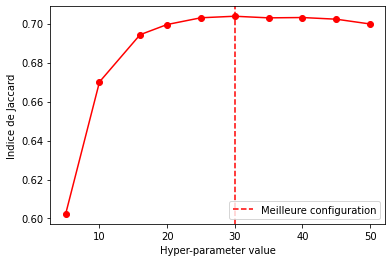

In [21]:
plot_hyperparameter_tuning(jaccard_coeff5)

In [ ]:
for value in [50,55,60,65]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff5[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff5[value]))

On obtient l'indice de Jaccard maximal: 0.6898886415035864 pour les valeurs d'hyperparamètre suivantes:
[45]


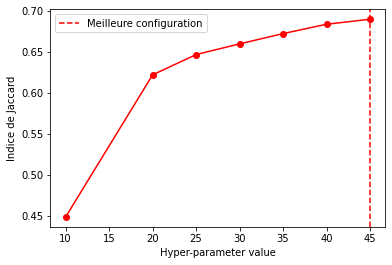

In [103]:
plot_hyperparameter_tuning(jaccard_coeff5)

In [ ]:
precision,recall,f1_score={},{},{}
resize_relation=2

for value in [15,20,25,30,35,40]:
    f1_score_moy=0
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        precision[label]=[]
        recall[label]=[]
        f1_score[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
            p,r,f=classifactionMetrics(res,groundtruth)
            precision[label].append(p)
            recall[label].append(r)
            f1_score[label].append(f)
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        f1_score_moy+=np.mean(f1_score[label])
    f1_score_moy=f1_score_moy/len(labels)
    res[value]=f1_score_moy
    print("the mean f1 score for hyperparameter value="+str(value)+" is "+str(f1_score_moy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

In [39]:
moy=0
for label in labels:
    moy+=np.mean(PCCs[label])
    print(np.mean(PCCs[label]))
moy=moy/len(labels)
moy

0.9689322916666666
0.9608912037037036
0.9611910095579451
0.98269994835225


0.9684286133201414

#### Optimisation sans ombre

In [147]:
jaccard_coeff2={}
resize_relation=2

for nb_samples in [5,10,15,20,25,30,35,40,45,50]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(500,600):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        #groundtruth[groundtruth<=170]=255
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
    for i in range(600,645):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff2[nb_samples]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(nb_samples)+" is "+str(jaccard_coeff2[nb_samples]))

the mean jaccard's coefficient for hyperparameter value=5 is 0.35667659585392403
the mean jaccard's coefficient for hyperparameter value=10 is 0.4728560714958886
the mean jaccard's coefficient for hyperparameter value=15 is 0.45824325585135034
the mean jaccard's coefficient for hyperparameter value=20 is 0.45541965064525136
the mean jaccard's coefficient for hyperparameter value=25 is 0.44743497763645196
the mean jaccard's coefficient for hyperparameter value=30 is 0.440264700619991
the mean jaccard's coefficient for hyperparameter value=35 is 0.4420953036418099
the mean jaccard's coefficient for hyperparameter value=40 is 0.4391429327578438
the mean jaccard's coefficient for hyperparameter value=45 is 0.44028657439300145
the mean jaccard's coefficient for hyperparameter value=50 is 0.43561207327353946


On obtient l'indice de Jaccard maximal: 0.4728560714958886 pour les valeurs d'hyperparamètre suivantes:
[10]


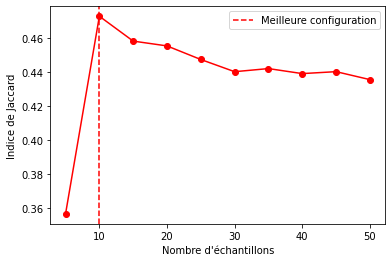

In [149]:
plot_hyperparameter_tuning(jaccard_coeff2,x_axis_title="Nombre d'échantillons")

In [150]:
jaccard_coeff3={}
resize_relation=2
nb_samples=20

for value in [1,2,4,6,8,10,12,15]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,value,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,value,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff3[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff3[value]))

the mean jaccard's coefficient for hyperparameter value=1 is 0.5248073031969116
the mean jaccard's coefficient for hyperparameter value=2 is 0.6071763506344812
the mean jaccard's coefficient for hyperparameter value=4 is 0.5829744870632266
the mean jaccard's coefficient for hyperparameter value=6 is 0.45902610509345027
the mean jaccard's coefficient for hyperparameter value=8 is 0.300788074979762
the mean jaccard's coefficient for hyperparameter value=10 is 0.19844478525241868
the mean jaccard's coefficient for hyperparameter value=12 is 0.14331462833002448
the mean jaccard's coefficient for hyperparameter value=15 is 0.09491830772214857


On obtient l'indice de Jaccard maximal: 0.6071763506344812 pour les valeurs d'hyperparamètre suivantes:
[2]


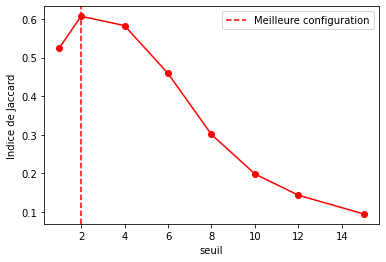

In [151]:
plot_hyperparameter_tuning(jaccard_coeff3,x_axis_title="seuil")

In [155]:
jaccard_coeff4={}
resize_relation=2
nb_samples=20
seuil=2

for value in [10,20,25,30,35,40,45]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff4[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff4[value]))

the mean jaccard's coefficient for hyperparameter value=10 is 0.5149122301364366
the mean jaccard's coefficient for hyperparameter value=20 is 0.6071043155226605
the mean jaccard's coefficient for hyperparameter value=25 is 0.6116813725316831
the mean jaccard's coefficient for hyperparameter value=30 is 0.6126106747688269
the mean jaccard's coefficient for hyperparameter value=35 is 0.6246559461639334
the mean jaccard's coefficient for hyperparameter value=40 is 0.6291247887164313
the mean jaccard's coefficient for hyperparameter value=45 is 0.6285416316294004


In [157]:
for value in [50,55,60]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff4[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff4[value]))

the mean jaccard's coefficient for hyperparameter value=50 is 0.6256908700920353
the mean jaccard's coefficient for hyperparameter value=55 is 0.6165758495986414
the mean jaccard's coefficient for hyperparameter value=60 is 0.614294917232224


On obtient l'indice de Jaccard maximal: 0.6291247887164313 pour les valeurs d'hyperparamètre suivantes:
[40]


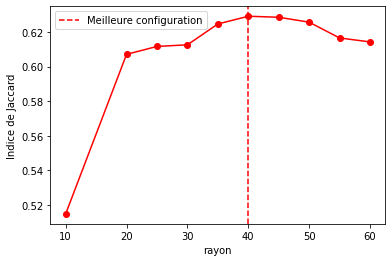

In [158]:
plot_hyperparameter_tuning(jaccard_coeff4,x_axis_title="rayon")

In [11]:
jaccard_coeff5={}
resize_relation=2
nb_samples=20
seuil=2
rayon=40

for value in [5,10,16,20,30]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff5[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff5[value]))

the mean jaccard's coefficient for hyperparameter value=5 is 0.47964402783652277
the mean jaccard's coefficient for hyperparameter value=10 is 0.5786652787013982
the mean jaccard's coefficient for hyperparameter value=16 is 0.6287220513357624
the mean jaccard's coefficient for hyperparameter value=20 is 0.6427252501866111
the mean jaccard's coefficient for hyperparameter value=30 is 0.6627136247976587


In [12]:
for value in [35,40,45,50,55]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff5[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff5[value]))

the mean jaccard's coefficient for hyperparameter value=35 is 0.6673243035481728
the mean jaccard's coefficient for hyperparameter value=40 is 0.673089103417352
the mean jaccard's coefficient for hyperparameter value=45 is 0.67445817664306
the mean jaccard's coefficient for hyperparameter value=50 is 0.6743845983549261
the mean jaccard's coefficient for hyperparameter value=55 is 0.6749294483068818


In [14]:
for value in [60,65,70,75]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff5[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff5[value]))

the mean jaccard's coefficient for hyperparameter value=60 is 0.6749852520409777
the mean jaccard's coefficient for hyperparameter value=65 is 0.6742055875339468
the mean jaccard's coefficient for hyperparameter value=70 is 0.674135606128593
the mean jaccard's coefficient for hyperparameter value=75 is 0.6747454907736478


On obtient l'indice de Jaccard maximal: 0.6749852520409777 pour les valeurs d'hyperparamètre suivantes:
[60]


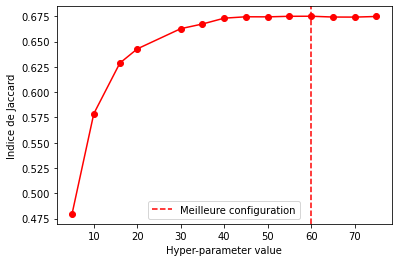

In [15]:
plot_hyperparameter_tuning(jaccard_coeff5)

#### Obtention des résultats

In [35]:
import cv2
resize_relation=1
label="highway"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=40
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,50,4,nb_samples,30)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


In [28]:
import cv2
resize_relation=1
label="highway"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,20,2,nb_samples,16)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe2").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


In [63]:
import cv2
resize_relation=1
label="pedestrians"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=40
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,50,4,nb_samples,30)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


In [11]:
import cv2
resize_relation=1
label="pedestrians"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,20,2,nb_samples,16)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe2").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


In [18]:
import cv2
resize_relation=1
label="office"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=40
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,50,4,nb_samples,30)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


In [41]:
import cv2
resize_relation=1
label="office"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,20,2,nb_samples,16)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe2").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


In [16]:
import cv2
resize_relation=1
label="PETS2006"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=40
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,50,4,nb_samples,30)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


### Comparaison

In [64]:
labels=["highway", "office", "pedestrians", "PETS2006"]
output_data_sem_seg,output_data_vibe=output_dataset(labels)

In [37]:
label="highway"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][469:]
for i in range(len(groundtruth_of_label)):
    out_sem_seg=io.imread(output_data_sem_seg[label][i+469])
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i+469])
    grdtruth=io.imread(groundtruth_of_label[i])
    grdtruth_c=np.copy(grdtruth)
    grdtruth_c[grdtruth_c>=50]=255
    #grdtruth[grdtruth<=50]=0
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth_c))
    grdtruth[grdtruth<=170]=0
    #grdtruth[grdtruth<=50]=0
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

In [60]:
np.unique(out_sem_seg)

array([  0, 255], dtype=uint8)

In [38]:
np.mean(jaccard_coeff_vibe)

0.5112247805021408

In [39]:
np.mean(jaccard_coeff_sem_seg)

0.5549399375954839

In [24]:
label="pedestrians"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][299:]
for i in range(len(groundtruth_of_label)-1):
    out_sem_seg=io.imread(output_data_sem_seg[label][i+299])
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i+299])
    grdtruth=io.imread(groundtruth_of_label[i])
    #grdtruth[grdtruth<=170]=0
    grdtruth[grdtruth>=50]=255
    #grdtruth[grdtruth<=50]=0
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

In [27]:
np.mean(jaccard_coeff_sem_seg)

0.6399453267665739

In [26]:
np.mean(jaccard_coeff_vibe)

0.6870762333609103

In [53]:
label="office"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][569:]
for i in range(len(groundtruth_of_label)-1):
    out_sem_seg=io.imread(output_data_sem_seg[label][i+569])
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i+569])
    grdtruth=io.imread(groundtruth_of_label[i])
    #grdtruth[grdtruth<=170]=0
    grdtruth[grdtruth>=50]=255
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

In [54]:
np.mean(jaccard_coeff_sem_seg)

0.8457899009246989

In [55]:
np.mean(jaccard_coeff_vibe)

0.23826819268675165

In [36]:
label="PETS2006"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][299:]
for i in range(len(groundtruth_of_label)-1):
    out_sem_seg=io.imread(output_data_sem_seg[label][i+299])
    out_sem_seg[out_sem_seg==169]=0
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i+299])
    grdtruth=io.imread(groundtruth_of_label[i])
    #grdtruth[grdtruth<=170]=0
    grdtruth[grdtruth>=50]=255
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

In [40]:
np.mean(jaccard_coeff_sem_seg)

0.6326603587576882

In [39]:
np.mean(jaccard_coeff_vibe)

0.35016146407671317